In [1]:
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go

from bs4 import BeautifulSoup
from importlib import reload

pd.set_option('display.max_colwidth', -1)

In [2]:
package_path = 'C:\\Users\\dietrich\\code\\'
sys.path.insert(0, package_path)

In [3]:
from pyMAPCO2 import scrape, load, iridium, plot, plot_plt, plot_ply

In [4]:
from sunburst_sensors.sunburst import sami
from sunburst_sensors.sunburst import mapco2

### I. Dashboard

#### 1. Units to scrape data for

In [5]:
systems_tested = ['0168', '0024', '0105', '0155', '0175']

#### 2a. Limit to a time range

In [6]:
t_start = '06/01/2017 00:00'
t_end = '06/08/2017 00:00'

#### 2b. Limit data to within a certain number of days  
Note: this overrides t_start and t_end values

In [7]:
days_in_past = 5

#### 3. Print verbose messages

In [8]:
verbose = True

#### 4. Local location of downloaded data

In [9]:
local_target = 'C:\\Users\\dietrich\\data\\rudics\\mapco2'

### II. Scrape Data  

#### 1A. Scrape Rudics server and generate file list to load

#### 1B. Load specified files

#### 1C. Load existing files based on systems_tested

In [10]:
f_list = []
s_list = []
for system in systems_tested:
    print(system)
    f_list_system = glob.glob(local_target + '\\' + system + '\\*')
    f_list = f_list + f_list_system
    s_list.append(system)
f_list
f_list[-1]

0168
0024
0105
0155
0175


'C:\\Users\\dietrich\\data\\rudics\\mapco2\\0175\\C0175_2017_06_07.txt'

#### 2. Create bytes filepath represenations and insert into DataFrame

In [11]:
bf_list = [f.encode('utf-8') for f in f_list]

In [12]:
dff = pd.DataFrame.from_dict({'filepath': bf_list})

#### 3. Get date of file data and filter based on t_start and t_end

In [13]:
def get_date(bfp):
    """
    Parameters
    ----------
    bfp : bytes, bytes filepath
    
    """
    fp_list = bfp.split(b'\\')
    fa = fp_list[-1]
    fb = fa.split(b'.')[0]
    fc = fb.split(b'_')
    fd = fc[1:]
    if len(fd) == 4:
        fd = fd[:-1]
    fe = (b'-').join(fd)
    return fe.decode('utf-8')

In [14]:
dff['datetime_str'] = dff.filepath.apply(get_date)

In [15]:
dff.filepath = dff.filepath.str.decode('utf-8')

In [16]:
dff['datetime64_ns'] = pd.to_datetime(dff.datetime_str)

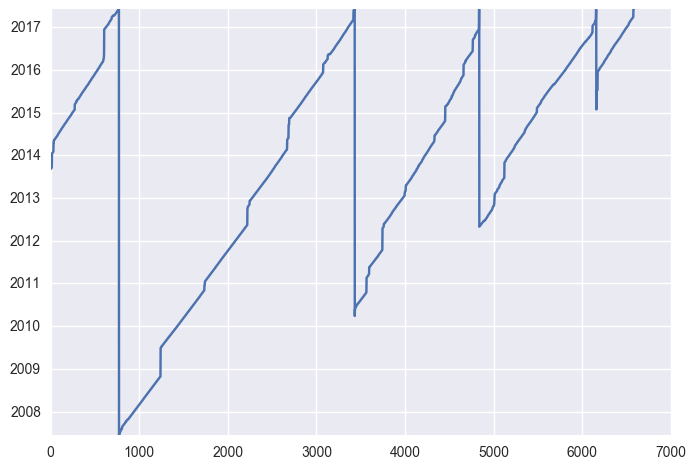

In [17]:
plt.plot(dff.datetime64_ns)
plt.show()

In [18]:
dffs = dff[(dff.datetime64_ns >= t_start) & (dff.datetime64_ns <= t_end)]

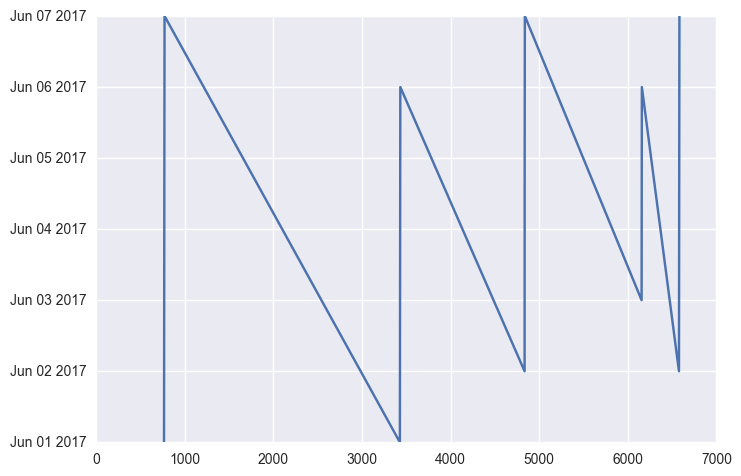

In [19]:
plt.plot(dffs.datetime64_ns)
plt.show()

### III. Insert all data into DataFrames

In [20]:
f_list = list(dffs.filepath)

In [21]:
df = load.file_batch(f_list, verbose=False)
df.reset_index(inplace=True, drop=True)

In [22]:
df.dtypes

mapco2_start       int64         
ph_sami_start      int64         
ph_seafet_start    int64         
sbe16_start        int64         
met_start          int64         
datetime           object        
datetime64_ns      datetime64[ns]
mapco2_end         int32         
ph_sami_end        int32         
ph_seafet_end      int32         
sbe16_end          int32         
met_end            int32         
source             object        
unit               object        
common_key         object        
sbe16_list         object        
ph_sami_list       object        
ph_seafet_list     object        
met_list           object        
co2_list           object        
dtype: object

#### 2. Clean SAMI pH data using sunburst_sensors.sunburst package  
Note: no more use of pyMAPCO2 package in this section

In [23]:
df.ph_sami_list = df.ph_sami_list.apply(mapco2.nested_list_strip)

In [24]:
df.ph_sami_list = df.ph_sami_list.apply(mapco2.remove_oa_delimiter)

In [25]:
df['datetime_ph_sami'] = df.ph_sami_list.apply(mapco2.extract_mapco2_datetime)

In [26]:
df['ph_sami_hex'] = df.ph_sami_list.apply(mapco2.extract_sami_hex)

In [27]:
df['ph_sami_data'] = ''
df['ph_sami_control'] = ''

In [28]:
df = df.apply(mapco2.split_sami_hex, axis=1)

In [29]:
ph = sami.PH()

In [30]:
df_sami = ph.df_from_hex(list(df.ph_sami_data))

In [31]:
reload(sami)
ph = sami.PH()
listpH = [ph.parse_hex(s) for s in list(df.ph_sami_data)]

### IV. Import all CO2 data

In [32]:
reload(iridium)
h, g, e, co2 = iridium.batch_co2_list(df.co2_list, verbose=False)

In [33]:
co2.system.unique()

array(['0168', '0024', '0105', '0155', '0175'], dtype=object)

In [34]:
co2.drop_duplicates(subset=['cycle', 'datetime64_ns', 'system'], inplace=True)

In [35]:
co2.system.unique()

array(['0168', '0024', '0105', '0155', '0175'], dtype=object)

In [36]:
list(co2.system.unique())

['0168', '0024', '0105', '0155', '0175']

In [37]:
co2.dtypes

cycle              object        
minute             float64       
licor_temp         float64       
licor_temp_std     float64       
licor_press        float64       
licor_press_std    float64       
xCO2               float64       
xCO2_std           object        
O2                 float64       
O2_std             float64       
RH                 float64       
RH_std             float64       
RH_temp            float64       
RH_temp_std        float64       
xCO2_raw1          float64       
xCO2_raw1_std      float64       
xCO2_raw2          float64       
xCO2_raw2_std      object        
common_key         object        
system             object        
datetime_str       object        
datetime64_ns      datetime64[ns]
dtype: object

In [38]:
co2_list = []
for system in co2.system.unique():
    for cycle in co2.cycle.unique():
        key = system + '_' + cycle
        _df = co2[(co2.system == system) & (co2.cycle == cycle)].copy()
        _df.sort_values(by='datetime64_ns', inplace=True)
        _df.reset_index(inplace=True, drop=True)
        co2_list.append((system, cycle, _df))

In [39]:
systems  = list(set([d[0] for d in co2_list]))
systems

['0175', '0105', '0024', '0168', '0155']

In [40]:
dict(enumerate(set([d[0] for d in co2_list])))
{v: k for k, v in dict(enumerate(set([d[0] for d in co2_list]))).items()}

{'0024': 2, '0105': 1, '0155': 4, '0168': 3, '0175': 0}

### V. Plot Data

In [41]:
reload(plot_ply)
fig = dict(data=plot_ply.ms_data(co2_list),
           layout=plot_ply.default_layout(xco2_sw_range=[300, 700]))
_f = 'Lab 1030 Data.html'
ply.plot(fig, output_type='file',
         auto_open=True, filename=_f,  show_link=False)

'file://C:\\Users\\dietrich\\code\\mapco2_tests\\Lab 1030 Data.html'